<a href="https://colab.research.google.com/github/AmayaDes/Neuro-Symbolic_PCOS-Detection-FYP/blob/main/notebooks/01_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amayajayarathna","key":"626c928eb8783b512c0b23b3d9582d83"}'}

In [21]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [22]:
!kaggle datasets download -d amayajayarathna/pcos-ultrasound-dataset-figshare-doi


Dataset URL: https://www.kaggle.com/datasets/amayajayarathna/pcos-ultrasound-dataset-figshare-doi
License(s): CC-BY-SA-4.0
pcos-ultrasound-dataset-figshare-doi.zip: Skipping, found more recently modified local copy (use --force to force download)


In [23]:
!unzip pcos-ultrasound-dataset-figshare-doi.zip


Streaming output truncated to the last 5000 lines.
  inflating: PCOS/noninfected/Image_001.jpg  
  inflating: PCOS/noninfected/Image_002.jpg  
  inflating: PCOS/noninfected/Image_003.jpg  
  inflating: PCOS/noninfected/Image_004.jpg  
  inflating: PCOS/noninfected/Image_005.jpg  
  inflating: PCOS/noninfected/Image_006.jpg  
  inflating: PCOS/noninfected/Image_007.jpg  
  inflating: PCOS/noninfected/Image_008.jpg  
  inflating: PCOS/noninfected/Image_009.jpg  
  inflating: PCOS/noninfected/Image_010.jpg  
  inflating: PCOS/noninfected/Image_011.jpg  
  inflating: PCOS/noninfected/Image_012.jpg  
  inflating: PCOS/noninfected/Image_013.jpg  
  inflating: PCOS/noninfected/Image_014.jpg  
  inflating: PCOS/noninfected/Image_015.jpg  
  inflating: PCOS/noninfected/Image_016.jpg  
  inflating: PCOS/noninfected/Image_017.jpg  
  inflating: PCOS/noninfected/Image_018.jpg  
  inflating: PCOS/noninfected/Image_019.jpg  
  inflating: PCOS/noninfected/Image_020.jpg  
  inflating: PCOS/noninfected

In [24]:
!ls


organized_pcos	    PCOS-Detection-FYP
organized_pcos.zip  pcos-ultrasound-dataset-figshare-doi.zip
PCOS		    sample_data


In [25]:
!ls PCOS


infected  noninfected


Removing old organized dataset...
Dataset found!
PCOS images: 6784
Normal images: 5000
After deduplication: 3996 images
Copying train files...


100%|██████████| 2797/2797 [00:00<00:00, 3112.06it/s]


Copying val files...


100%|██████████| 599/599 [00:00<00:00, 3218.80it/s]


Copying test files...


100%|██████████| 600/600 [00:00<00:00, 2497.96it/s]


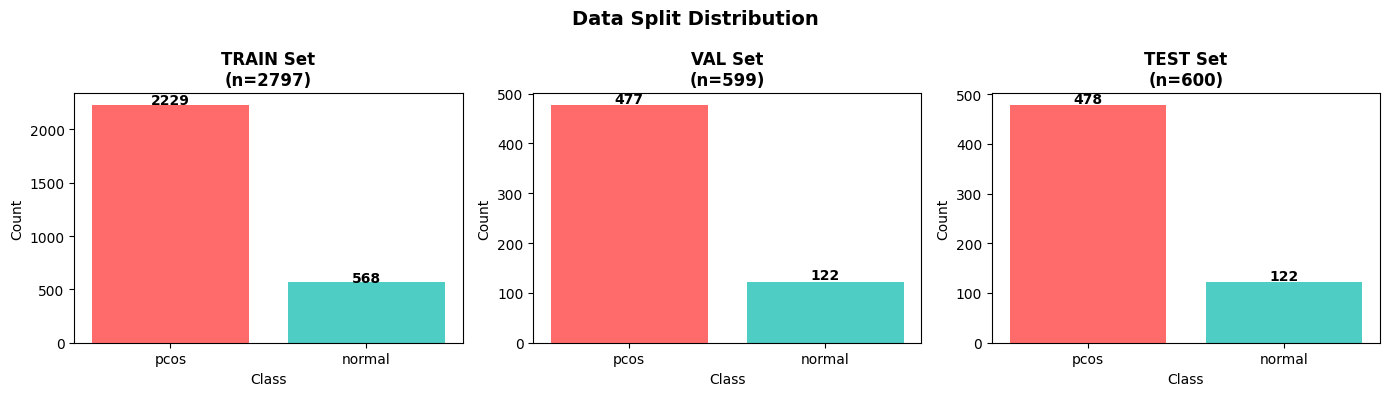

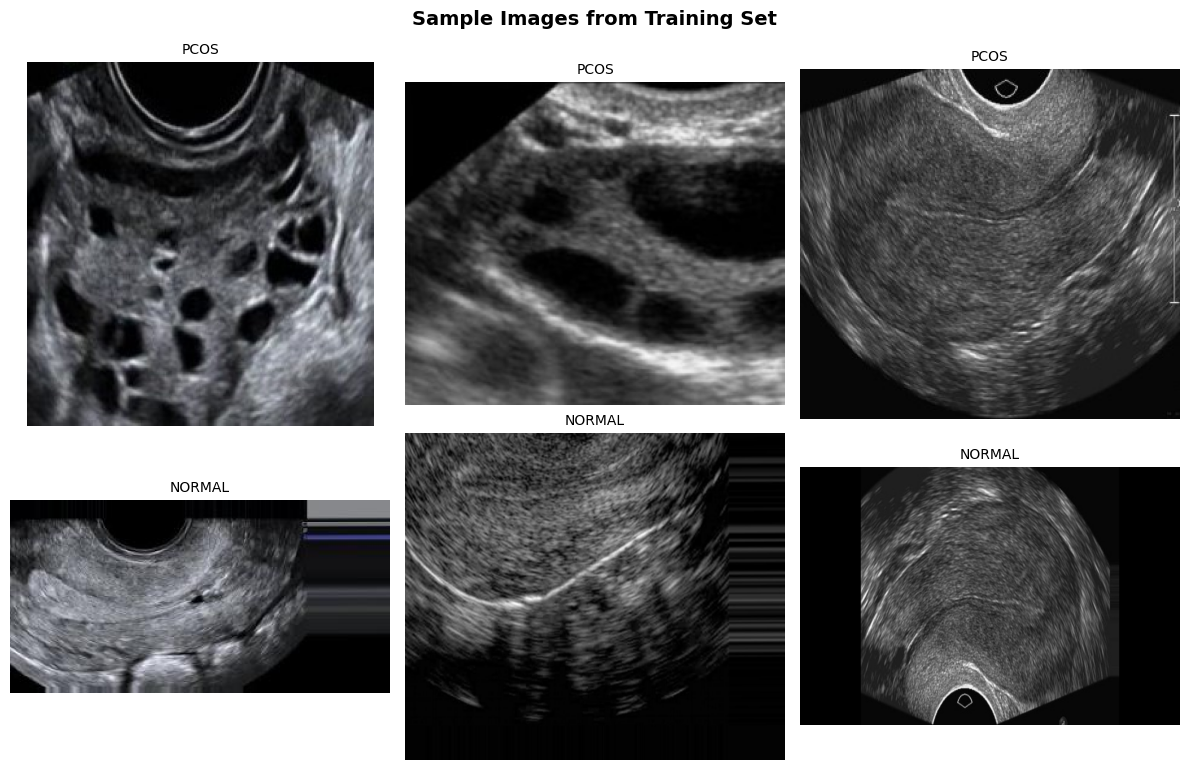


PIPELINE COMPLETE!

Output location: /content/organized_pcos

Created files:
   - train/ (2797 images)
   - val/ (599 images)
   - test/ (600 images)
   - train_metadata.csv
   - val_metadata.csv
   - test_metadata.csv
   - split_distribution.png
   - sample_images.png

Class Distribution:
Split      PCOS       Normal     Total     
----------------------------------------
Train      2229       568        2797      
Val        477        122        599       
Test       478        122        600       


In [26]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm
import hashlib
import matplotlib.pyplot as plt

# Kaggle paths
BASE_DIR = "/content/PCOS"
OUTPUT_DIR = "/content/organized_pcos"

# Clean old organized data if exists
if os.path.exists(OUTPUT_DIR):
    print("Removing old organized dataset...")
    shutil.rmtree(OUTPUT_DIR)

# Verify dataset exists
if not os.path.exists(BASE_DIR):
    raise Exception(f"Dataset not found at {BASE_DIR}")

print("Dataset found!")
print("PCOS images:", len(os.listdir(f"{BASE_DIR}/infected")))
print("Normal images:", len(os.listdir(f"{BASE_DIR}/noninfected")))


# ========================
# PCOSDataLoader
# ========================

class PCOSDataLoader:

    def __init__(self, base_dir):
        self.base_dir = base_dir
        self.pcos_dir = os.path.join(base_dir, "infected")
        self.normal_dir = os.path.join(base_dir, "noninfected")
        self.image_data = []

    def compute_image_hash(self, image_path):
        with open(image_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()

    def load_images(self):
        pcos_images = [f for f in os.listdir(self.pcos_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        normal_images = [f for f in os.listdir(self.normal_dir)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for img in pcos_images:
            self.image_data.append({
                'filename': img,
                'label': 1,
                'label_name': 'pcos',
                'source_path': os.path.join(self.pcos_dir, img)
            })

        for img in normal_images:
            self.image_data.append({
                'filename': img,
                'label': 0,
                'label_name': 'normal',
                'source_path': os.path.join(self.normal_dir, img)
            })

        # Deduplication
        unique_images = {}
        for item in self.image_data:
            h = self.compute_image_hash(item['source_path'])
            if h not in unique_images:
                unique_images[h] = item

        self.image_data = list(unique_images.values())
        print(f"After deduplication: {len(self.image_data)} images")
        return self

    def get_dataframe(self):
        return pd.DataFrame(self.image_data)


# ========================
# DataSplitter
# ========================

class DataSplitter:

    def __init__(self, df, train=0.7, val=0.15, test=0.15):
        self.df = df
        self.train = train
        self.val = val
        self.test = test

    def split(self):
        train_df, temp_df = train_test_split(
            self.df,
            test_size=(self.val + self.test),
            stratify=self.df['label'],
            random_state=42
        )

        val_ratio = self.val / (self.val + self.test)
        val_df, test_df = train_test_split(
            temp_df,
            test_size=(1 - val_ratio),
            stratify=temp_df['label'],
            random_state=42
        )

        return train_df, val_df, test_df


# ========================
# DataOrganizer
# ========================

class DataOrganizer:

    def __init__(self, out_dir, train_df, val_df, test_df):
        self.out_dir = out_dir
        self.splits = {
            'train': train_df,
            'val': val_df,
            'test': test_df
        }

    def create_structure(self):
        for split in ['train', 'val', 'test']:
            for cls in ['pcos', 'normal']:
                os.makedirs(os.path.join(self.out_dir, split, cls), exist_ok=True)

    def copy_files(self):
        for split, df in self.splits.items():
            print(f"Copying {split} files...")
            for _, row in tqdm(df.iterrows(), total=len(df)):
                dst = os.path.join(self.out_dir, split, row['label_name'], row['filename'])
                shutil.copy(row['source_path'], dst)

    def save_metadata(self):
        for split, df in self.splits.items():
            df = df.copy()
            df['image_path'] = df.apply(
                lambda r: os.path.join(self.out_dir, split, r['label_name'], r['filename']),
                axis=1
            )
            df.to_csv(os.path.join(self.out_dir, f"{split}_metadata.csv"), index=False)

    def plot_split_distribution(self):
        """Visualize class distribution across splits"""
        fig, axes = plt.subplots(1, 3, figsize=(14, 4))

        for idx, (split, df) in enumerate(self.splits.items()):
            counts = df['label_name'].value_counts()
            colors = ['#ff6b6b', '#4ecdc4']

            axes[idx].bar(counts.index, counts.values, color=colors)
            axes[idx].set_title(f'{split.upper()} Set\n(n={len(df)})', fontsize=12, fontweight='bold')
            axes[idx].set_ylabel('Count')
            axes[idx].set_xlabel('Class')

            for i, v in enumerate(counts.values):
                axes[idx].text(i, v + 5, str(v), ha='center', fontweight='bold')

        plt.suptitle('Data Split Distribution', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(self.out_dir, 'split_distribution.png'), dpi=150, bbox_inches='tight')
        plt.show()

    def plot_sample_images(self, n_samples=3):
        """Display sample images from each class"""
        fig, axes = plt.subplots(2, n_samples, figsize=(12, 8))

        train_df = self.splits['train']

        for row_idx, label_name in enumerate(['pcos', 'normal']):
            samples = train_df[train_df['label_name'] == label_name].sample(n=n_samples, random_state=42)

            for col_idx, (_, sample) in enumerate(samples.iterrows()):
                img_path = os.path.join(self.out_dir, 'train', label_name, sample['filename'])
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                axes[row_idx, col_idx].imshow(img)
                axes[row_idx, col_idx].axis('off')
                axes[row_idx, col_idx].set_title(f'{label_name.upper()}', fontsize=10)

        plt.suptitle('Sample Images from Training Set', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(self.out_dir, 'sample_images.png'), dpi=150, bbox_inches='tight')
        plt.show()


# ========================
# RUN PIPELINE
# ========================

loader = PCOSDataLoader(BASE_DIR).load_images()
df = loader.get_dataframe()

splitter = DataSplitter(df)
train_df, val_df, test_df = splitter.split()

organizer = DataOrganizer(OUTPUT_DIR, train_df, val_df, test_df)
organizer.create_structure()
organizer.copy_files()
organizer.save_metadata()
organizer.plot_split_distribution()
organizer.plot_sample_images()

# ========================
# SUMMARY
# ========================

print("\n" + "="*50)
print("PIPELINE COMPLETE!")
print("="*50)
print(f"\nOutput location: {OUTPUT_DIR}")
print(f"\nCreated files:")
print(f"   - train/ ({len(train_df)} images)")
print(f"   - val/ ({len(val_df)} images)")
print(f"   - test/ ({len(test_df)} images)")
print(f"   - train_metadata.csv")
print(f"   - val_metadata.csv")
print(f"   - test_metadata.csv")
print(f"   - split_distribution.png")
print(f"   - sample_images.png")

print(f"\nClass Distribution:")
print(f"{'Split':<10} {'PCOS':<10} {'Normal':<10} {'Total':<10}")
print("-" * 40)
for split, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    pcos_count = len(split_df[split_df['label'] == 1])
    normal_count = len(split_df[split_df['label'] == 0])
    print(f"{split:<10} {pcos_count:<10} {normal_count:<10} {len(split_df):<10}")